In [20]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn.functional as F

## Preparing dataset

In [130]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#      transforms.RandomHorizontalFlip(1),
#      transforms.Pad(4),
#      transforms.RandomCrop(32),
#      ])

# batch_size = 4

# # cifar_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# # cifar_test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# cifar_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
# cifar_test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

# training_size, testing_size = len(cifar_train_set.data), len(cifar_test_set.data)
# original_train_set, original_test_set = torch.empty((training_size, 3, 32, 32), dtype=float), torch.empty((testing_size, 3, 32, 32), dtype=float)
# original_train_set_label, original_test_set_label = [], []

# for i, data in enumerate(cifar_train_set.data):
#     data = Image.fromarray(data)
#     data = transform(data)
#     original_train_set[i] = data
#     original_train_set_label.append(cifar_train_set.targets[i])

# for i, data in enumerate(cifar_test_set.data):
#     data = Image.fromarray(data)
#     data = transform(data)
#     original_test_set[i] = data
#     original_test_set_label.append(cifar_test_set.targets[i]) 

# original_train_set_label, original_test_set_label = F.one_hot(torch.tensor(original_train_set_label)), F.one_hot(torch.tensor(original_test_set_label))


In [137]:
import random
import math

class Mixer:
    def __init__(self):
        self.transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                        transforms.RandomHorizontalFlip(1),
                                        transforms.Pad(4),
                                        transforms.RandomCrop(32),
                                        ])
        self.cifar_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
        self.cifar_test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
    
    def mix_images_bc(self, img1, img2):
        #First between class mixing method proposed
        ratio = random.uniform(0, 1)
        while ratio == 0:
            ratio = random.uniform(0, 1)
        mixed_image = img1 * ratio + img2 * (1 - ratio)

        return mixed_image, ratio

    def mix_images_bc_plus(self, img1, img2):
        #Better mixing method
        ratio = random.uniform(0, 1)
        while ratio == 0:
            ratio = random.uniform(0, 1)
        i1_mean, i2_mean = torch.mean(img1), torch.mean(img2)
        i1_std, i2_std = torch.std(img1), torch.std(img2)
        p = 1 / (1 + (i1_std / i2_std) * ((1 - ratio) / ratio)) 

        mixed_image = (p * (img1 - i1_mean) + (1 - p) * (img2 - i2_mean)) / (math.sqrt(p ** 2 + (1 - p) ** 2))
        return mixed_image, ratio
        
    def get_test_dataset(self):
        testing_size = len(self.cifar_test_set.data)
        original_test_set = torch.empty((testing_size, 3, 32, 32), dtype=float)
        original_test_set_label = []
        
        for i, data in enumerate(self.cifar_test_set.data):
            data = Image.fromarray(data)
            data = self.transform(data)
            original_test_set[i] = data
            original_test_set_label.append(self.cifar_test_set.targets[i])

        original_test_set_label = F.one_hot(torch.tensor(original_test_set_label))

        return original_test_set, original_test_set_label

    def get_train_dataset(self):
        training_size = len(self.cifar_train_set.data)
        original_train_set = torch.empty((training_size, 3, 32, 32), dtype=float)
        original_train_set_label = []
        
        for i, data in enumerate(self.cifar_train_set.data):
            data = Image.fromarray(data)
            data = self.transform(data)
            original_train_set[i] = data
            original_train_set_label.append(self.cifar_train_set.targets[i])

        original_train_set_label = F.one_hot(torch.tensor(original_train_set_label))

        return original_train_set, original_train_set_label
        

    def mix_image_dataset(self, images, labels, algo="bc"):
        mixed_images = torch.empty(images.shape)
        mix_ratios = torch.empty((images.shape[0], len(labels[0])))
        mixing_algo = self.mix_images_bc_plus if algo == "bc+" else self.mix_images_bc
        total = 0

        random.seed(10)
        for offset in range(1, 100):
            if total >= images.shape[0]: break
            for i in range(images.shape[0] - 1):
                if total >= images.shape[0]: break
                if i + offset < images.shape[0] and not torch.all(torch.eq(labels[i], labels[i + offset])):
                    m_i, ratio = mixing_algo(images[i], images[i + offset])
                    mixed_images[i] = m_i
                    mix_ratios[i] = torch.mul(labels[i],ratio) + torch.mul(labels[i + offset],(1 - ratio))
                    total += 1

        
        return mixed_images, mix_ratios
            
                

In [133]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [138]:
mixer = Mixer()

origianl_train_set, original_train_set_label = mixer.get_train_dataset()
original_test_set, original_test_set_label = mixer.get_test_dataset()

mixed_train_images, mixed_train_labels = mixer.mix_image_dataset(original_train_set, original_train_set_label, algo="bc")
plus_mixed_train_images, plus_mixed_train_labels = mixer.mix_image_dataset(original_train_set, original_train_set_label, algo="bc+") 

mixed_test_images, mixed_test_labels = mixer.mix_image_dataset(original_test_set, original_test_set_label, algo="bc")
plus_mixed_test_images, plus_mixed_test_labels = mixer.mix_image_dataset(original_test_set, original_test_set_label, algo="bc+") 

Files already downloaded and verified
Files already downloaded and verified


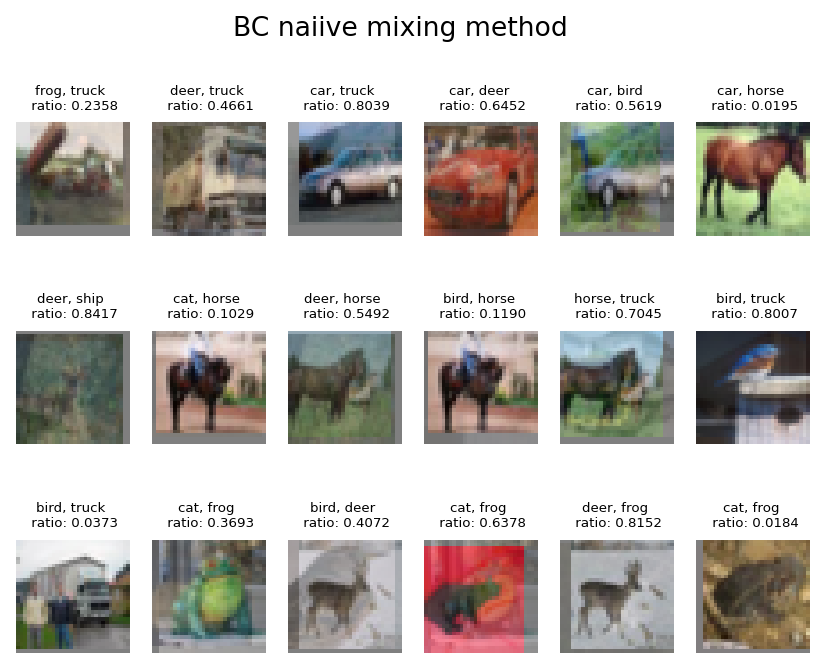

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

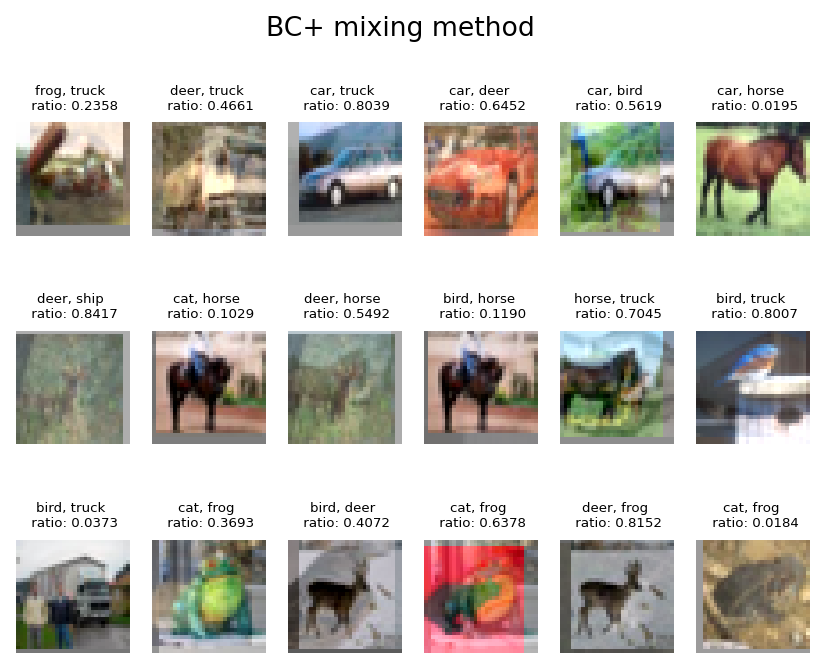

In [139]:
#Preview of the images within our mixed images
#BC naiive mixing method plot
fig, axs = plt.subplots(3, 6)
fig.set_dpi(160)
fig.suptitle("BC naiive mixing method")
for i in range(3):
    for j in range(6):
        r_index = i * 8 + j
        img = mixed_train_images[r_index] / 2 + 0.5
        axs[i, j].imshow(np.transpose(img, (1, 2,0)))
        axs[i, j].axis('off')
        image_label = torch.nonzero(mixed_train_labels[r_index])
        axs[i,j].set_title("{}, {} \n ratio: {:.4f}".format(classes[image_label[0]],classes[image_label[1]], float(mixed_train_labels[r_index][image_label[0]])),
        fontdict={'fontsize':6})

plt.show()

#BC+ mixing method plot
fig, axs = plt.subplots(3, 6)
fig.set_dpi(160)
fig.suptitle("BC+ mixing method")
for i in range(3):
    for j in range(6):
        r_index = i * 8 + j
        img = plus_mixed_train_images[r_index] / 2 + 0.5
        axs[i, j].imshow(np.transpose(img, (1, 2,0)))
        axs[i, j].axis('off')
        image_label = torch.nonzero(plus_mixed_train_labels[r_index])
        axs[i,j].set_title("{}, {} \n ratio: {:.4f}".format(classes[image_label[0]],classes[image_label[1]], float(plus_mixed_train_labels[r_index][image_label[0]])),
        fontdict={'fontsize':6})

plt.show()

In [140]:
from torch.utils.data import Dataset

class DatasetIterator(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
  
    def __len__(self):
        return self.images.shape[0]
  
    def __getitem__(self, index):
        # return self.transform(self.images[index]), self.transform(self.labels[index])
        return self.images[index].detach().cpu().numpy(), self.labels[index].detach().cpu().numpy()

In [234]:
class ModelManager:
    def __init__(self, classifier, optimizer, l_function = None):
        self.classifier = classifier
        self.optimizer = optimizer
        self.l_function = l_function if l_function is not None else self.kl_divergence
    
    def kl_divergence(self, pred, true):
        entropy = -1 * torch.sum(true[torch.nonzero(true, as_tuple=True)] * torch.log(true[torch.nonzero(true, as_tuple=True)]))
        crossEntropy = -1 * torch.sum(true * torch.nn.functional.log_softmax(pred))
        # print(f"Cross entropy has NaN: {torch.any(torch.isnan(crossEntropy))}, Entropy has NaN: {torch.any(torch.isnan(entropy))}")
        return (crossEntropy - entropy) / pred.shape[0]
        # loss = (true * (torch.log(true + 1e-10) - F.log_softmax(pred, 1))).sum() / pred.shape[0]
        return loss

    
    def train(self, train_loader):
        self.classifier.train()
        for batch_idx, (images, targets) in enumerate(train_loader):
            self.optimizer.zero_grad()
            output = self.classifier(images)
            output = torch.nn.functional.softmax(output)
            # targets = torch.nn.functional.softmax(targets)
            loss = self.l_function(output, targets)

            if torch.any(torch.isnan(loss)):
                print(loss)
                print("Exited Loop cause failed")
                print("Predict is:")
                print(output)
                break
            loss.backward()
            self.optimizer.step()

            if not batch_idx % 100:
                print(f"Current Loss: {loss}")
    
    def test(self, test_loader):
        correct, total = 0, 0
        
        with torch.no_grad():
            for i, data in enumerate(test_loader):
                images, labels = data
                outputs = self.classifier(images.float())
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                _, true_labels = torch.max(labels, 1)
                correct += (sum([1 for x in range(labels.size(0)) if predicted[x] == true_labels[x]]))
        
        print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

## Resnet-18 Pretrained Model

In [235]:
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn

In [236]:
#Training a model now
resnet18 = models.resnet18(pretrained = False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, mixed_train_labels[0].shape[0])
resnet18.layer4.requires_grad = True
resnet18.layer3.requires_grad = True
resnet18.conv1.requires_grad = True
resnet18.layer1.requires_grad = True
resnet18.layer2.requires_grad = True

optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.8)
l_function = torch.nn.KLDivLoss(reduction="batchmean")

resnet18_model_manager = ModelManager(resnet18, optimizer=optimizer, l_function=l_function)
cifar10_dataset = DatasetIterator(mixed_train_images, mixed_train_labels)
train_loader = torch.utils.data.DataLoader(cifar10_dataset, batch_size=4, shuffle=True)


In [237]:
epochs = 2

for e in range(epochs):
    resnet18_model_manager.train(train_loader) 

/var/folders/qb/l_dpmp1j6dn9k_wz77sln_440000gn/T/ipykernel_71752/1866680712.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = torch.nn.functional.softmax(output)


Current Loss: -0.5862325429916382
Current Loss: -0.5451756119728088
Current Loss: -0.5365612506866455
tensor(nan, grad_fn=<DivBackward0>)
Exited Loop cause failed
Predict is:
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<SoftmaxBackward0>)
tensor(nan, grad_fn=<DivBackward0>)
Exited Loop cause failed
Predict is:
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<SoftmaxBackward0>)


In [68]:
cifar10_test_dataset = DatasetIterator(original_test_set, original_train_set_label)
test_loader = torch.utils.data.DataLoader(cifar10_test_dataset, batch_size=4, shuffle=False)
resnet18_model_manager.test(test_loader) 

Accuracy of the network on the test images: 9 %


## Convnet -- From Between-Learning paper

In [238]:
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch

In [239]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [254]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_channels, out_channels, ksize, stride = 1, pad = 0, bias=False):
        super(ConvBNReLU, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, ksize, stride, pad, bias=bias)
        self.bn = torch.nn.BatchNorm2d(out_channels, eps=1e-5)
    
    def forward(self, x):
        output = self.conv(x)
        output = self.bn(output)

        return torch.relu(output)

class ConvNet(nn.Module):
    def __init__(self, n_classes):
        super(ConvNet, self).__init__()
        self.conv11 = ConvBNReLU(3, 64, 3, pad = 1)
        self.conv12 = ConvBNReLU(64, 64, 3, pad = 1)
        self.conv21 = ConvBNReLU(64, 128, 3, pad = 1)
        self.conv22 = ConvBNReLU(128, 128, 3, pad = 1)
        self.conv31 = ConvBNReLU(128, 256, 3, pad = 1)
        self.conv32 = ConvBNReLU(256, 256, 3, pad = 1)
        self.conv33 = ConvBNReLU(256, 256, 3, pad = 1)
        self.conv34 = ConvBNReLU(256, 256, 3, pad = 1)
        self.fc4 = torch.nn.Linear(256*4*4, 1024)
        self.fc5 = torch.nn.Linear(1024, 1024)
        self.fc6 = torch.nn.Linear(1024, n_classes)
    
    def forward(self, x):
        output = self.conv11(x)
        output = self.conv12(output)
        output = nn.functional.max_pool2d(output, 2)


        output = self.conv21(output)
        output = self.conv22(output)
        output = nn.functional.max_pool2d(output, 2)


        output = self.conv31(output)
        output = self.conv32(output)
        output = self.conv33(output)
        output = self.conv34(output)
        output = nn.functional.max_pool2d(output, 2)
        print(output.shape)

        output = nn.functional.dropout(nn.functional.relu(self.fc4(output)))
        output = nn.functional.dropout(nn.functional.relu(self.fc5(output)))

        return self.fc6(output)

In [255]:
#Training a model now

#10 classes for CIFAR_10
convnet = ConvNet(10)
optimizer = optim.SGD(convnet.parameters(), lr=0.01, momentum=0.8)

convnet_model_manager = ModelManager(convnet, optimizer=optimizer, l_function=None)
cifar10_dataset = DatasetIterator(mixed_train_images, mixed_train_labels)
train_loader = torch.utils.data.DataLoader(cifar10_dataset, batch_size=4, shuffle=True)

In [256]:
epochs = 5

for e in range(epochs):
    convnet_model_manager.train(train_loader) 

torch.Size([4, 256, 4, 4])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4096x4 and 4096x1024)

In [253]:
cifar10_test_dataset = DatasetIterator(original_test_set, original_train_set_label)
test_loader = torch.utils.data.DataLoader(cifar10_test_dataset, batch_size=4, shuffle=False)
resnet18_model_manager.test(test_loader) 

KeyboardInterrupt: 